##Recommendation System using Collaborative Filtering

Sistem rekomendasi merupakan sebuah metode yang digunakan untuk memberikan rekomendasi pada sebuah produk seperti buku, musik dan film dengan memberikan nilai prediksi tertinggi pada penggunanya. Sistem rekomendasi saat ini masih bisa ditingkatkan lagi kualitasnya, sehingga dengan menggunakan metode baru diharapkan dapat lebih meningkatkan lagi nilai relevansi dari hasil rekomendasi yang diberikan daripada sistem-sistem sebelumnya. Selain itu perkembangan film didunia juga setiap harinya semakin meningkat dengan berbagai jenis genre yang dimiliki, sehingga membuat para penonton film merasa kesulitan untuk memilih film apa yang akan ditonton. Maka dari itu, diperlukan adanya sebuah sistem yang dapat memberikan rekomendasi dari penonton film lainnya. Pada proyek ini membuat sistem rekomendasi film menggunakan collaborative filtering dengan algoritma K-Nearest Neighbors.

Sistem rekomendasi menjadi semakin penting di dunia yang sibuk saat ini. Orang selalu mencari produk/layanan yang paling cocok untuk mereka. Oleh karena itu, sistem rekomendasi penting karena membantu mereka membuat pilihan yang tepat, tanpa harus mengeluarkan sumber daya lain yang besar.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

**Mount ke gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Dataset**

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/TMDB Movie Dataset/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/TMDB Movie Dataset/tmdb_5000_credits.csv')

### **Data Understanding & Cleaning** 

In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


##### **Convert JSON into strings**

In [ ]:
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) 
    movies.loc[index,'genres'] = str(list1)

movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)

movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies'] = str(list1)

credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)
    
credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

In [ ]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",http://www.avatarmovie.com/,19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"['Adventure', 'Fantasy', 'Action']",http://disney.go.com/disneypictures/pirates/,285,"['ocean', 'drug abuse', 'exotic island', 'east...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"['Action', 'Adventure', 'Crime']",http://www.sonypictures.com/movies/spectre/,206647,"['spy', 'based on novel', 'secret agent', 'seq...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",http://www.thedarkknightrises.com/,49026,"['dc comics', 'crime fighter', 'terrorist', 's...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"['Action', 'Adventure', 'Science Fiction']",http://movies.disney.com/john-carter,49529,"['based on novel', 'mars', 'medallion', 'space...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,['Walt Disney Pictures'],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
credits.head()

,movie_id,title,cast,director
0,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron
1,285,Pirates of the Caribbean: At World's End,"['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",Gore Verbinski
2,206647,Spectre,"['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",Sam Mendes
3,49026,The Dark Knight Rises,"['Christian Bale', 'Michael Caine', 'Gary Oldm...",Christopher Nolan
4,49529,John Carter,"['Taylor Kitsch', 'Lynn Collins', 'Samantha Mo...",Andrew Stanton


#### **Gabungkan kolom-kolom antara dua file**

In [ ]:
movies = movies.merge(credits,left_on='id',right_on='movie_id',how='left')
movies = movies[['id','original_title','genres','cast','vote_average','director','keywords']]

**Mengecek film nomor pertama**

In [ ]:
movies.iloc[1]

id                                                              285
original_title             Pirates of the Caribbean: At World's End
genres                           ['Adventure', 'Fantasy', 'Action']
cast              ['Johnny Depp', 'Orlando Bloom', 'Keira Knight...
vote_average                                                    6.9
director                                             Gore Verbinski
keywords          ['ocean', 'drug abuse', 'exotic island', 'east...
Name: 1, dtype: object

In [ ]:
movies.shape

(4803, 7)

### **Data Preparation untuk Kolom Genres**

**Memvisualisasikan Genres Terbanyak**

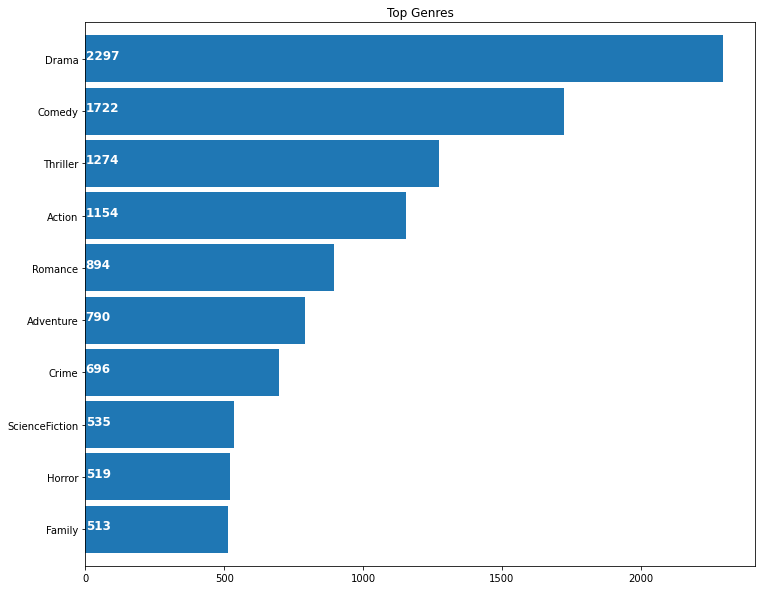

In [ ]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

**Menampilkan list genre yang unik pada dataset**

In [ ]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10]

['Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western']

##### **One Hot Encoding untuk Genres**

In [ ]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

### **Data Preparation untuk Kolom Cast**

In [ ]:
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:4]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

##### **One Hot Encoding untuk Kolom Cast**

In [ ]:
castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

def binary(cast_list):
    binaryList = []
    
    for genre in castList:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))
movies['cast_bin'].head()

0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...
2    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3    [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
4    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
Name: cast_bin, dtype: object

### **Data Preparation untuk Kolom Director**

##### **One Hot Encoding untuk Kolom Director**

In [ ]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)

directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

def binary(director_list):
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

movies['director_bin'] = movies['director'].apply(lambda x: binary(x))
movies.head()

,original_title,genres,vote_average,genres_bin,cast_bin,new_id,director,director_bin,words_bin
0,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]",7.2,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,James Cameron,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...",1,Gore Verbinski,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectre,"[Action, Adventure, Crime]",6.3,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,Sam Mendes,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",3,Christopher Nolan,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,John Carter,"[Action, Adventure, ScienceFiction]",6.1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",4,Andrew Stanton,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **Data Preparation for Kolom Keywords**


In [ ]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')

words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

def binary(words):
    binaryList = []
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))
movies = movies[(movies['vote_average']!=0)] 
movies = movies[movies['director']!='']
movies.head()

,id,original_title,genres,cast,vote_average,director,keywords,genres_bin,cast_bin,director_bin,words_bin
0,19995,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","SamWorthington,SigourneyWeaver,StephenLang,Zoe...",7.2,James Cameron,"[3d, alien, alienplanet, antiwar, battle, cgi,...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","JohnnyDepp,KeiraKnightley,OrlandoBloom,Stellan...",6.9,Gore Verbinski,"[aftercreditsstinger, afterlife, alliance, cal...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,206647,Spectre,"[Action, Adventure, Crime]","ChristophWaltz,DanielCraig,LéaSeydoux,RalphFie...",6.3,Sam Mendes,"[basedonnovel, britishsecretservice, mi6, secr...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","AnneHathaway,ChristianBale,GaryOldman,MichaelC...",7.6,Christopher Nolan,"[batman, burglar, catburglar, catwoman, cover-...","[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,49529,John Carter,"[Action, Adventure, ScienceFiction]","LynnCollins,SamanthaMorton,TaylorKitsch,Willem...",6.1,Andrew Stanton,"[19thcentury, 3d, alien, alienrace, basedonnov...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **Find Similarity between Movies**

**Membuat fungsi Similarity() dengan metriks distance Cosine Similarity untuk mencari kemiripan antara dua film**

In [ ]:
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance

**Mengecek similarity antara dua film dengan fungsi Similarity()**

In [ ]:
Similarity(2,4) 

1.6381516362402322

In [ ]:
Similarity(9,12)

1.3472087901661332

In [ ]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
movies.head()

,original_title,genres,vote_average,genres_bin,cast_bin,new_id,director,director_bin,words_bin
0,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]",7.2,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,James Cameron,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...",1,Gore Verbinski,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectre,"[Action, Adventure, Crime]",6.3,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,Sam Mendes,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",3,Christopher Nolan,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,John Carter,"[Action, Adventure, ScienceFiction]",6.1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",4,Andrew Stanton,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **Recommend Movies Function using KNN**

Kemudian kita menggunakan fungsi similarity yang telah kita buat sebelumnya pada algoritma K-NN. Kita membuat fungsi recommend_movies() untuk merekomendasikan film dan memprediksi rating seperti sebagai berikut: 

In [ ]:
import operator

def recommend_movies(name):
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]  
        print( movies.iloc[neighbor[0]][0]+" | Genres: "+str(movies.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(movies.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))

**Memanggil fungsi recommend_movies() yang akan menampilkan 10 film yang mirip dan prediksi rating dari film**

In [ ]:
recommend_movies('Avengers: Age of Ultron')

Selected Movie:  Avengers: Age of Ultron


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



Recommended Movies: 

The Avengers | Genres: 'ScienceFiction','Action','Adventure' | Rating: 7.4
Serenity | Genres: 'ScienceFiction','Action','Adventure','Thriller' | Rating: 7.4
Captain America: Civil War | Genres: 'Adventure','Action','ScienceFiction' | Rating: 7.1
Captain America: The Winter Soldier | Genres: 'Action','Adventure','ScienceFiction' | Rating: 7.6
Pacific Rim | Genres: 'Action','ScienceFiction','Adventure' | Rating: 6.7
Independence Day: Resurgence | Genres: 'Action','Adventure','ScienceFiction' | Rating: 4.9
Captain America: The First Avenger | Genres: 'Action','Adventure','ScienceFiction' | Rating: 6.6
Iron Man | Genres: 'Action','ScienceFiction','Adventure' | Rating: 7.4
Megaforce | Genres: 'Adventure','Action','ScienceFiction' | Rating: 3.5
Iron Man 3 | Genres: 'Action','Adventure','ScienceFiction' | Rating: 6.8


The predicted rating for Avengers: Age of Ultron is: 6.540000
The actual rating for Avengers: Age of Ultron is 7.300000


In [ ]:
recommend_movies('How to Train Your Dragon')

Selected Movie:  How to Train Your Dragon


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



Recommended Movies: 

The Croods | Genres: 'Adventure','Animation','Comedy','Family','Fantasy' | Rating: 6.8
Lilo & Stitch | Genres: 'Animation','Family' | Rating: 7.1
Epic | Genres: 'Animation','Adventure','Family','Fantasy' | Rating: 6.4
Legend of the Guardians: The Owls of Ga'Hoole | Genres: 'Animation','Adventure','Family','Fantasy' | Rating: 6.5
Dragon Nest: Warriors' Dawn | Genres: 'Adventure','Family','Fantasy','Animation' | Rating: 6.8
The House of Magic | Genres: 'Family','Fantasy','Animation','Adventure' | Rating: 6.3
Arthur et les Minimoys | Genres: 'Adventure','Fantasy','Animation','Family' | Rating: 6.0
Mars Needs Moms | Genres: 'Adventure','Animation','Family' | Rating: 5.5
The Little Prince | Genres: 'Adventure','Animation','Fantasy' | Rating: 7.6
Савва. Сердце воина | Genres: 'Fantasy','Adventure','Animation' | Rating: 6.4


The predicted rating for How to Train Your Dragon is: 6.540000
The actual rating for How to Train Your Dragon is 7.500000
